In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
ds_cesm = xr.open_dataset("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind/ds.zarr", engine="zarr")
ds_cesm = ds_cesm.chunk({"member": 1, "time": 100, "lat": -1, "lon": -1})
dh = DataHandler(ds_cesm, "/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind/results")
exp_cesm = JetFindingExperiment(dh)
jets_cesm, _, _ = exp_cesm.track_jets()
props_as_df = exp_cesm.props_as_df(True)
da_cesm = ds_cesm["s"].sel(time=ds_cesm.time.dt.season=="JJA")
dh = DataHandler(da_cesm, "/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind/results")
exp_s_cesm = Experiment(dh)
props_as_df_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8]))

In [3]:
kwargs_som = dict(
    nx=6,
    ny=6,
    activation_distance="euclidean",
    PBC=True,
    init="pca",
    return_type=RAW_REALSPACE,
    sigma=2,
    sigmaN=0.1,
    dask_chunks=(500, -1),
    train_kwargs=dict(num_epochs=20),
)
net, centers, labels = exp_s_cesm.som_cluster(**kwargs_som)
nx, ny, metric = kwargs_som["nx"], kwargs_som["ny"], kwargs_som["activation_distance"]
ds_center_path = exp_s_cesm.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")
ds_ = ds_cesm.sel(time=ds_cesm.time.dt.season=="JJA")
if not ds_center_path.is_file():
    ds_ = _compute(ds_, progress=True)
    ds_center = labels_to_centers(labels, ds_)
    ds_center.to_netcdf(ds_center_path)
else:
    ds_center = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={**determine_sample_dims(ds_), "cluster": np.arange(net.n_nodes)})

In [4]:
def get_persistent_jet_spells(props_as_df, metric: Literal["persistence", "com_speed"], jet: Literal["EDJ", "STJ"], season: list | str | None = None, minlen: int = 2, q: float = 0.1):
    props_as_df = extract_season_from_df(props_as_df, season)
    index_columns = get_index_columns(props_as_df)
    index = props_as_df[index_columns].unique(maintain_order=True)
    onejet = props_as_df.filter(pl.col("jet") == jet)
    out = onejet[metric]
    if metric == "com_speed":
        out = (out < out.quantile(q))
    else:
        out = (out > out.quantile(1 - q))
    out = out.rle().struct.unnest()
    out = out.with_columns(start=pl.lit(0).append(pl.col("len").cum_sum().slice(0, pl.col("len").len() - 1)))
    nt_before, nt_after = 8, 8
    out = out.filter(pl.col("value"), pl.col("len") >= minlen).with_columns(
        range=pl.int_ranges(pl.col("start") - nt_before, pl.col("start") + pl.col("len") + nt_after),
        relative_index=pl.int_ranges(-nt_before, pl.col("len") + nt_after),
    )
    out = out.with_row_index("persistent_spell").explode(["range", "relative_index"])
    out = out.filter(pl.col("range") < len(index))
    out = out.with_columns(index[out["range"]])
    out = out.join(props_as_df, on=index_columns).drop("value", "start", "range")
    return out

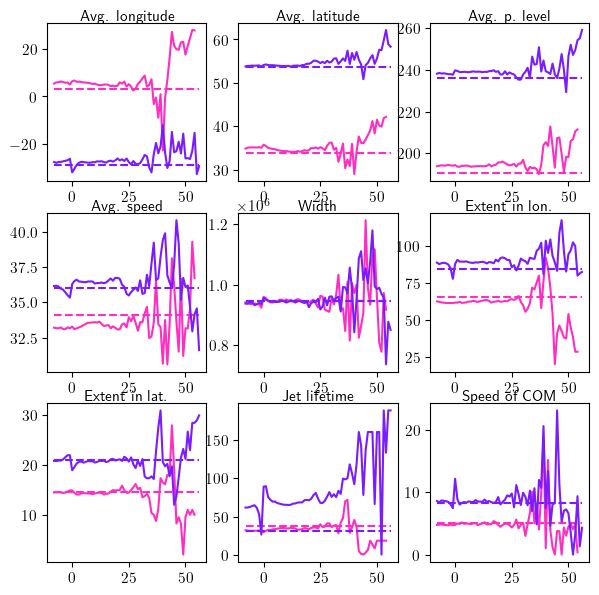

In [19]:
season = "JJA"
props_cesm = props_as_df
persistent_spells = get_persistent_jet_spells(props_cesm, "persistence", "EDJ", season=season, minlen=2)
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = persistent_spells.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = extract_season_from_df(props_cesm, season).group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])
fig.savefig(f"{FIGURES}/future_persistent_spells/pers_EDJ")

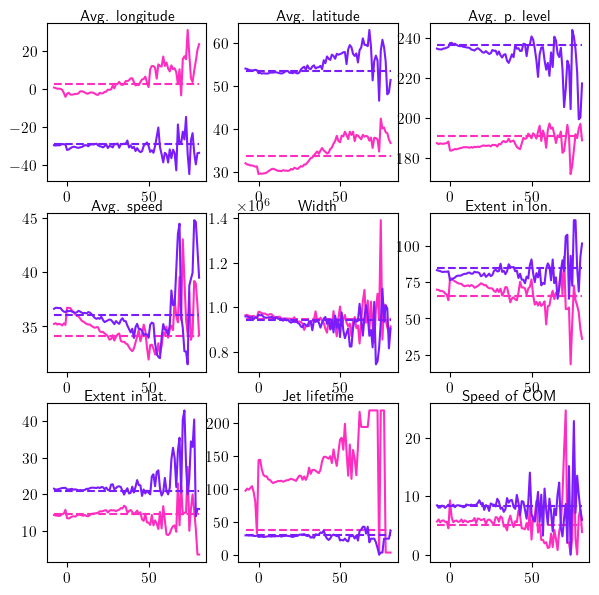

In [20]:
season = "JJA"
persistent_spells = get_persistent_jet_spells(props_cesm, "persistence", "STJ", season=season, minlen=2)
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = persistent_spells.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = extract_season_from_df(props_cesm, season).group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])
fig.savefig(f"{FIGURES}/future_persistent_spells/pers_STJ")

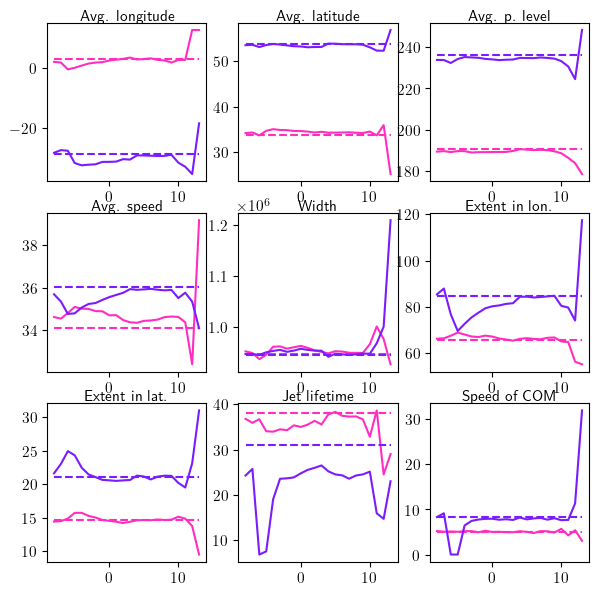

In [21]:
season = "JJA"
persistent_spells = get_persistent_jet_spells(props_cesm, "com_speed", "EDJ", season=season, minlen=2, q=0.1)
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = persistent_spells.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = extract_season_from_df(props_cesm, season).group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])
fig.savefig(f"{FIGURES}/future_persistent_spells/com_speed_EDJ")

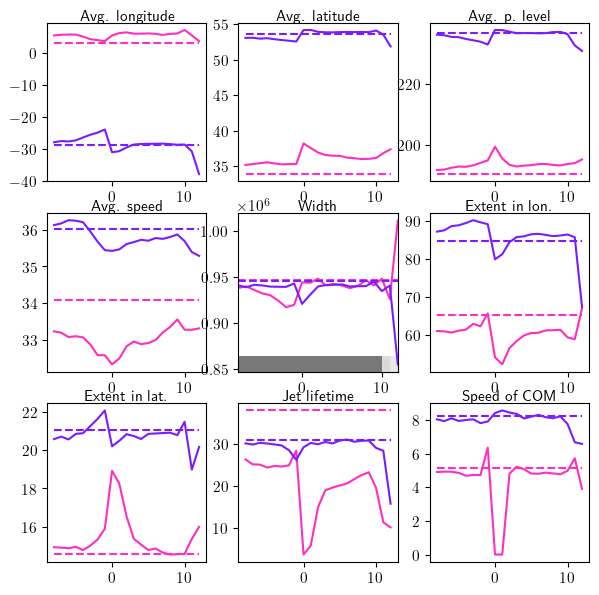

In [22]:
season = "JJA"
persistent_spells = get_persistent_jet_spells(props_cesm, "com_speed", "STJ", season=season, minlen=2, q=0.15)
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = persistent_spells.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
cmap = colormaps.cet_l_grey_r
cmap = LinearSegmentedColormap.from_list(
    "mod_grey", 
    cmap(np.linspace(0.1, 0.73, 200)), N=200
)
norm = BoundaryNorm(MaxNLocator(200).tick_values(0, mean_ps["alive"].max()), cmap.N)
positive_mask = x.astype(int) > 0
means = extract_season_from_df(props_cesm, season).group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    alive = to_plot["alive"].to_numpy()
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 1:
            ax.set_title(PRETTIER_VARNAME[data_var])
        if data_var == "width" and j==1:
            ylim = ax.get_ylim()
            ybounds = ylim[0] + np.asarray([0, 0.1 * (ylim[1] - ylim[0])])
            im = ax.pcolormesh(
                x.astype(float), ybounds, alive[None, :-1], zorder=-10, norm=norm,
                cmap=cmap, alpha=0.7
            )
fig.savefig(f"{FIGURES}/future_persistent_spells/com_speed_STJ")

In [23]:
def get_persistent_jet_spells_from_som(props_as_df, labels, minlen: int = 4):
    labels_df = pl.from_pandas(labels.to_dataframe().reset_index())
    labels_df = labels_df.cast({"time": props_as_df["time"].dtype})
    props_as_df = props_as_df.filter(pl.col("time").is_in(labels_df["time"]))
    index_columns = get_index_columns(props_as_df)
    index = props_as_df[index_columns].unique(maintain_order=True)

    out = labels_df["labels"].rle().struct.unnest()
    out = out.filter(pl.col("len") >= minlen)
    out = out.with_columns(start=pl.lit(0).append(pl.col("len").cum_sum().slice(0, pl.col("len").len() - 1)))
    nt_before, nt_after = 8, 8
    out = out.filter(pl.col("len") >= minlen).with_columns(
        range=pl.int_ranges(pl.col("start") - nt_before, pl.col("start") + pl.col("len") + nt_after),
        relative_index=pl.int_ranges(-nt_before, pl.col("len") + nt_after),
    )
    out = out.with_row_index("persistent_spell").explode(["range", "relative_index"])
    out = out.filter(pl.col("range") < len(index))
    out = out.with_columns(index[out["range"]])
    out = out.join(props_as_df, on=index_columns).drop("start", "range")
    return out

persistent_spells = get_persistent_jet_spells_from_som(props_as_df, labels, minlen=6)

In [24]:
labels_df = pl.from_pandas(labels.to_dataframe().reset_index())
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = persistent_spells.group_by(["value", "relative_index", "jet"]).agg(**aggs).sort(["value", "relative_index", "jet"])
props_on_som = labels_df.join(props_as_df.cast({"time": labels_df["time"].dtype}), on="time")
props_on_som = props_on_som.drop("time").group_by(["labels", "jet"], maintain_order=True).mean().sort(["labels", "jet"])

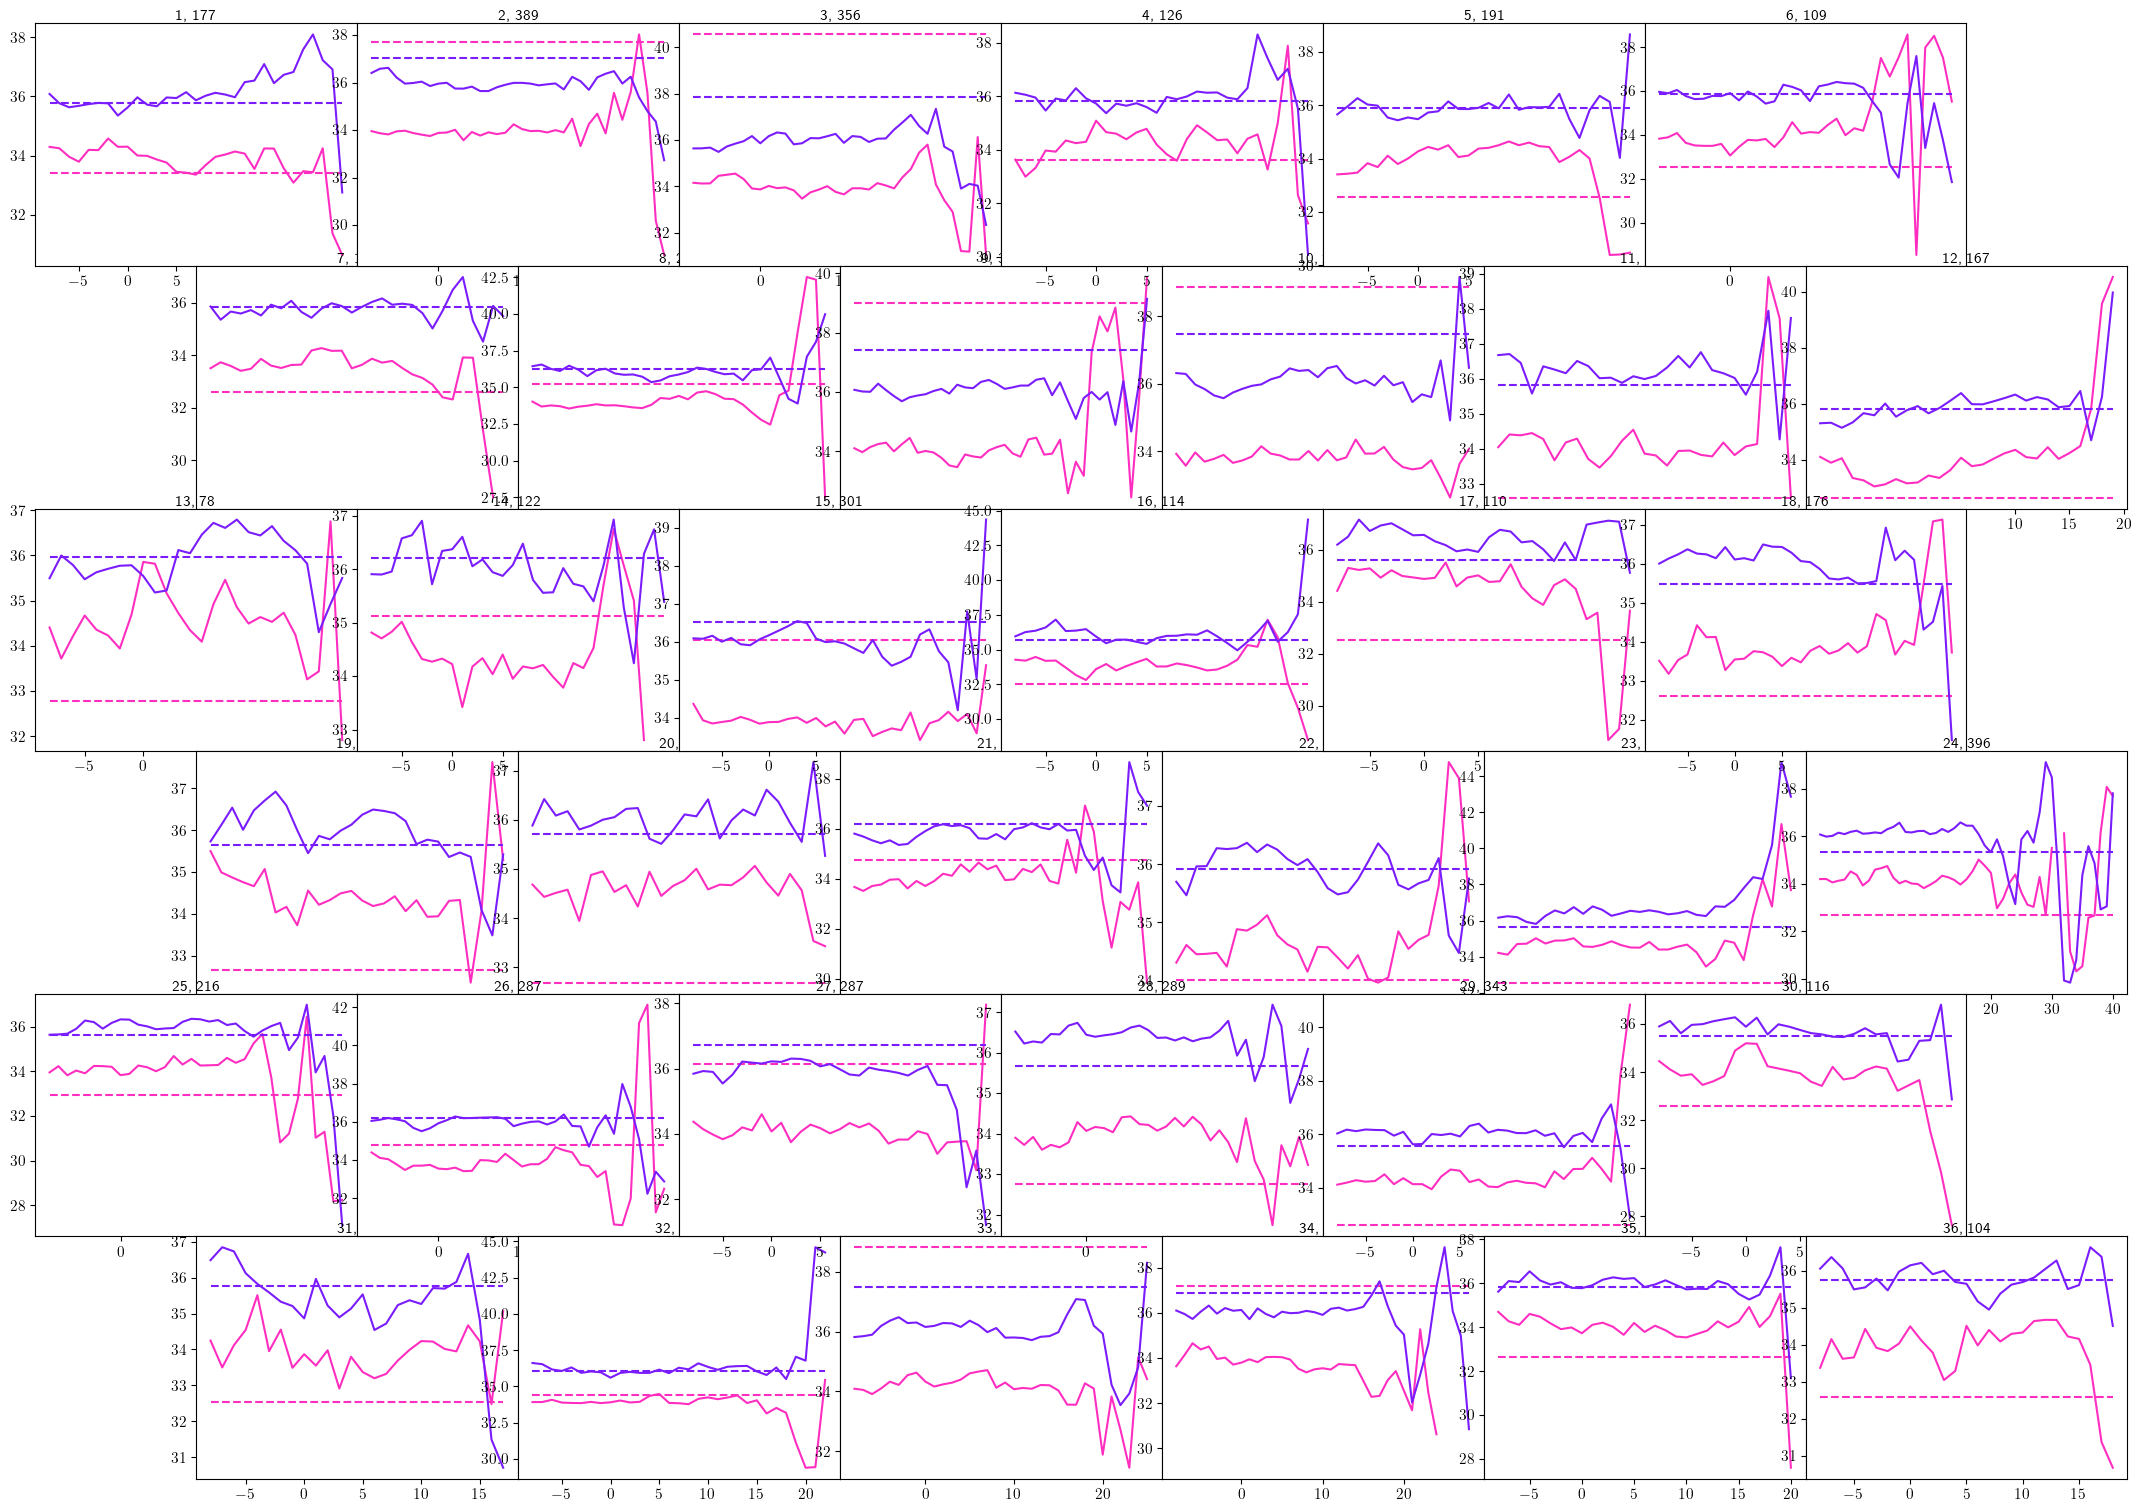

In [25]:
x = mean_ps["relative_index"].unique()
data_var = "mean_s"
many_colors = colormaps.cet_g_bw(np.linspace(0, 1, 256))
fig, axes = honeycomb_panel(net.y, net.x, ratio = 0.7)
axes = axes.ravel()
for value in range(net.x * net.y):
    ax = axes[value]
    for j, jet in enumerate(["STJ", "EDJ"]):
        to_plot = mean_ps.filter(pl.col("value") == value, pl.col("jet") == jet)
        x_ = x[:len(to_plot)]
        ax.plot(x_, to_plot[data_var], color=COLORS[2 - j])
        this_mean = props_on_som.filter(pl.col("labels") == value, pl.col("jet") == jet)
        if len(x_) == 0:
            continue
        ax.plot([x_[0], x_[-1]], [this_mean[data_var], this_mean[data_var]], ls="dashed", color=COLORS[2 - j])
    title = value + 1
    try:
        title = f"{title}, {to_plot['alive'][0]}"
    except IndexError:
        pass
    ax.set_title(title)


In [26]:
mean_ps = persistent_spells.group_by(["relative_index", "jet"]).agg(**aggs).sort(["relative_index", "jet"])

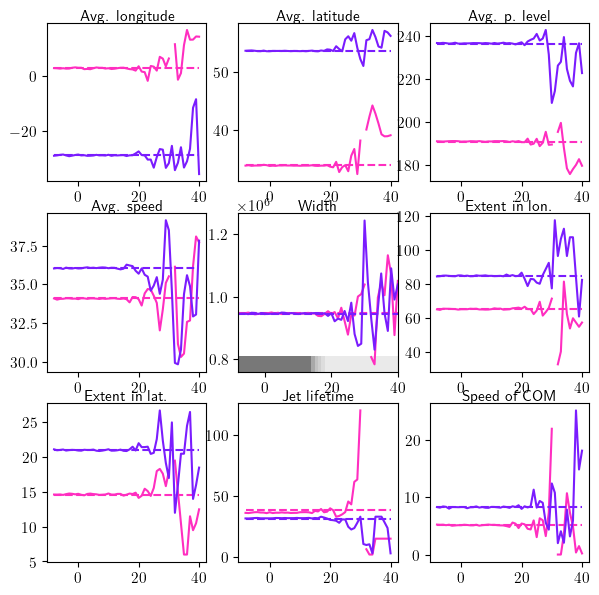

In [27]:
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
cmap = colormaps.cet_l_grey_r
cmap = LinearSegmentedColormap.from_list(
    "mod_grey", 
    cmap(np.linspace(0.1, 0.73, 200)), N=200
)
norm = BoundaryNorm(MaxNLocator(10).tick_values(0, mean_ps["alive"].max()), cmap.N)
x = mean_ps["relative_index"].unique().to_numpy()
positive_mask = x.astype(int) > 0
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    alive = to_plot["alive"].to_numpy()
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])
        if data_var == "width" and j==1:
            ylim = ax.get_ylim()
            ybounds = ylim[0] + np.asarray([0, 0.1 * (ylim[1] - ylim[0])])
            im = ax.pcolormesh(
                x.astype(float), ybounds, alive[None, :-1], zorder=-10, norm=norm,
                cmap=cmap, alpha=0.7
            )
fig.savefig(f"{FIGURES}/future_persistent_spells/from_som")